In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-darkgrid')

from measures import kaplan_meier, nelson_aalen
from measures import xCI, xAUCt, xROCt, ipc_weights

from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.util import Surv
from sksurv.nonparametric import kaplan_meier_estimator, nelson_aalen_estimator
from sksurv.metrics import concordance_index_censored, concordance_index_ipcw

In [2]:
df = pd.read_csv('datasets/support2_preprocessed.csv').sample(frac=1., random_state=23)

s = df['death'].values
t = df['d.time'].values

x = df.drop(['death', 'd.time'], axis=1).values

test_idx = len(df) * 3 // 5

s_train = s[:test_idx]
s_test = s[test_idx:]

t_train = t[:test_idx]
t_test = t[test_idx:]

x_train = x[:test_idx]
x_test = x[test_idx:]

black_test = df['race_black'][test_idx:].values == 1
white_test = df['race_white'][test_idx:].values == 1

# Verify Kaplan-Meier, Nelson-Aalen, and Censoring KM

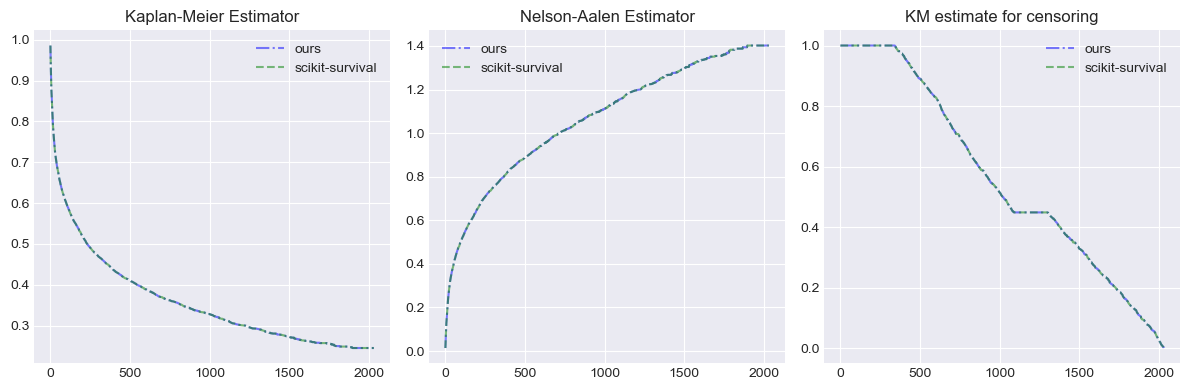

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

ax[0].plot(*kaplan_meier(s_train, t_train)[:2], 'b-.', alpha=0.5, label='ours')
ax[0].plot(*kaplan_meier_estimator(s_train == 1, t_train), 'g--', alpha=0.5, label='scikit-survival')
ax[0].set_title('Kaplan-Meier Estimator')
ax[0].legend()

ax[1].plot(*nelson_aalen(s_train, t_train)[:2], 'b-.', alpha=0.5, label='ours')
ax[1].plot(*nelson_aalen_estimator(s_train == 1, t_train), 'g--', alpha=0.5, label='scikit-survival')
ax[1].set_title('Nelson-Aalen Estimator')
ax[1].legend()

ax[2].plot(*kaplan_meier(1 - s_train, t_train)[:2], 'b-.', alpha=0.5, label='ours')
ax[2].plot(*kaplan_meier_estimator(s_train == 0, t_train), 'g--', alpha=0.5, label='scikit-survival')
ax[2].set_title('KM estimate for censoring')
ax[2].legend()

plt.tight_layout()
plt.show()

# Verify CI and IPCW CI calculations

In [4]:
pred_risk = CoxPHSurvivalAnalysis(alpha=.1).fit(
    x_train,
    Surv().from_arrays(s_train == 1, t_train)
).predict(x_test)

In [5]:
tau = None

print('CI (ours) = %.4f' % xCI(s_test, t_test, pred_risk))

print('CI (scikit-survival) = %.4f' % concordance_index_censored(
    s_test == 1, t_test, pred_risk)[0])

print('IPCW CI (ours) (estimate censoring from training set) = %.4f' % xCI(
    s_test, t_test, pred_risk, weights=ipc_weights(s_train, t_train, s_test, t_test, tau=tau)))

print('IPCW CI (scikit-survival) (estimate censoring from training set) = %.4f' % concordance_index_ipcw(
    Surv().from_arrays(s_train == 1, t_train),
    Surv().from_arrays(s_test == 1, t_test),
    pred_risk, tau=tau)[0])

print('IPCW CI (ours) (estimate censoring from test set) = %.4f' % xCI(
    s_test, t_test, pred_risk, weights=ipc_weights(s_test, t_test, s_test, t_test, tau=tau)))

print('IPCW CI (scikit-survival) (estimate censoring from test set) = %.4f' % concordance_index_ipcw(
    Surv().from_arrays(s_test == 1, t_test),
    Surv().from_arrays(s_test == 1, t_test),
    pred_risk, tau=tau)[0])

CI (ours) = 0.7476
CI (scikit-survival) = 0.7475
IPCW CI (ours) (estimate censoring from training set) = 0.7349
IPCW CI (scikit-survival) (estimate censoring from training set) = 0.7349
IPCW CI (ours) (estimate censoring from test set) = 0.7363
IPCW CI (scikit-survival) (estimate censoring from test set) = 0.7363


# Calculate xCI with and without IPCW

In [6]:
print('Without IPCW:')

for g1, l1 in zip([black_test, white_test], ['Black', 'White']):

    for g2, l2 in zip([black_test, white_test], ['Black', 'White']):

        print('xCI %s-%s = %.4f' % (
            l1, l2,
            xCI(
                s_test, t_test, pred_risk,
                g1_bool=g1, g2_bool=g2,
            )
        ))

print()
print('With IPCW:')

for g1, l1 in zip([black_test, white_test], ['Black', 'White']):

    for g2, l2 in zip([black_test, white_test], ['Black', 'White']):

        print('xCI %s-%s = %.4f' % (
            l1, l2,
            xCI(
                s_test, t_test, pred_risk,
                weights=ipc_weights(s_train, t_train, s_test, t_test, tau='auto'),
                g1_bool=g1, g2_bool=g2,
            )
        ))

Without IPCW:
xCI Black-Black = 0.7635
xCI Black-White = 0.7301
xCI White-Black = 0.7813
xCI White-White = 0.7426

With IPCW:
xCI Black-Black = 0.7532
xCI Black-White = 0.7183
xCI White-Black = 0.7710
xCI White-White = 0.7314


# Compute xAUC<sub>t</sub> and xROC<sub>t</sub>

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8), sharey='row')

times = np.linspace(500, 2000, 100)
time = 1600

black_test = df['race_black'][test_idx:].values == 1
white_test = df['race_white'][test_idx:].values == 1

auct = xAUCt(
    s_test, t_test, pred_risk, times,
    g1_bool=black_test | white_test,
    g2_bool=black_test | white_test
)

ax[0, 0].plot(times, auct, label='All-All')

tprt, fprt, _ = xROCt(
    s_test, t_test, pred_risk, time,
    g1_bool=black_test | white_test,
    g2_bool=black_test | white_test
)

ax[1, 0].plot(fprt, tprt, label='All-All')

for g1, l1 in zip([black_test, white_test], ['Black', 'White']):
    
    for g2, l2 in zip([black_test, white_test], ['Black', 'White']):
        
        auct = xAUCt(
            s_test, t_test, pred_risk, times,
            g1_bool=g1,
            g2_bool=g2
        )

        ax[0, 1].plot(times, auct, label='%s-%s' % (l1, l2))

        tprt, fprt, _ = xROCt(
            s_test, t_test, pred_risk, time,
            g1_bool=g1,
            g2_bool=g2
        )

        ax[1, 1].plot(fprt, tprt, label='%s-%s' % (l1, l2))

for i in range(2):

    ax[0, i].set_ylabel('xAUC$_t$')
    ax[0, i].set_xlabel('Time (t)')
    ax[0, i].legend()

    ax[1, i].plot([0, 1], [0, 1], 'k--')
    ax[1, i].set_ylabel('True Positive Rate (t=%i)' % time)
    ax[1, i].set_xlabel('False Positive Rate (t=%i)' % time)
    ax[1, i].legend()

plt.tight_layout()
plt.show()